In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax

import numpy as np

In [2]:
# From VectorQuantizer2 in modules/vqvae/quantize.py
class VectorQuantizer(nn.Module):
    n_e: int
    e_dim: int
    beta: float
    remap: str = None
    unknown_index: str = "random"
    sane_index_shape: bool = False
    legacy: bool = True

    def setup(self):
        self.embedding = self.param('embedding', nn.initializers.uniform(scale=1.0 / self.n_e), (self.n_e, self.e_dim))
        if self.remap is not None:
            self.used = self.param('used', lambda rng, shape: jnp.array(np.load(self.remap)), (self.n_e,))
            self.re_embed = self.used.shape[0]
            if self.unknown_index == "extra":
                self.unknown_index = self.re_embed
                self.re_embed += 1
            print(f"Remapping {self.n_e} indices to {self.re_embed} indices. "
                  f"Using {self.unknown_index} for unknown indices.")
        else:
            self.re_embed = self.n_e

    def remap_to_used(self, inds):
        ishape = inds.shape
        assert len(ishape) > 1
        inds = inds.reshape(ishape[0], -1)
        used = self.used
        match = (inds[:, :, None] == used[None, None, ...]).astype(jnp.int32)
        new = jnp.argmax(match, axis=-1)
        unknown = jnp.sum(match, axis=-1) < 1
        if self.unknown_index == "random":
            new = jnp.where(unknown, jax.random.randint(jax.random.PRNGKey(0), new.shape, 0, self.re_embed), new)
        else:
            new = jnp.where(unknown, self.unknown_index, new)
        return new.reshape(ishape)

    def unmap_to_all(self, inds):
        ishape = inds.shape
        assert len(ishape) > 1
        inds = inds.reshape(ishape[0], -1)
        used = self.used
        if self.re_embed > used.shape[0]:  # extra token
            inds = jnp.where(inds >= used.shape[0], 0, inds)  # simply set to zero
        back = used[inds]
        return back.reshape(ishape)

    def __call__(self, z, temp=None, rescale_logits=False, return_logits=False):
        assert temp is None or temp == 1.0, "Only for interface compatible with Gumbel"
        assert rescale_logits == False, "Only for interface compatible with Gumbel"
        assert return_logits == False, "Only for interface compatible with Gumbel"
        # z = jnp.transpose(z, (0, 2, 3, 1))
        z_flattened = jnp.reshape(z, [-1, self.e_dim])

        d = (jnp.sum(z_flattened ** 2, axis=1, keepdims=True) +
             jnp.sum(self.embedding ** 2, axis=1) -
             2 * jnp.dot(z_flattened, self.embedding.T))

        min_encoding_indices = jnp.argmin(d, axis=1)
        z_q = self.embedding[min_encoding_indices]
        z_q = jnp.reshape(z_q, z.shape)

        if not self.legacy:
            loss = self.beta * jnp.mean((jax.lax.stop_gradient(z_q) - z) ** 2) + \
                   jnp.mean((z_q - jax.lax.stop_gradient(z)) ** 2)
        else:
            loss = jnp.mean((jax.lax.stop_gradient(z_q) - z) ** 2) + \
                   self.beta * jnp.mean((z_q - jax.lax.stop_gradient(z)) ** 2)

        z_q = z + jax.lax.stop_gradient(z_q - z)

        # z_q = jnp.transpose(z_q, (0, 3, 1, 2))

        if self.remap is not None:
            min_encoding_indices = min_encoding_indices.reshape(z.shape[0], -1)
            min_encoding_indices = self.remap_to_used(min_encoding_indices)
            min_encoding_indices = min_encoding_indices.reshape(-1)

        if self.sane_index_shape:
            min_encoding_indices = min_encoding_indices.reshape(z_q.shape[0], z_q.shape[2], z_q.shape[3])

        return z_q, loss, (None, None, min_encoding_indices)

    def get_codebook_entry(self, indices, shape):
        if self.remap is not None:
            indices = indices.reshape(shape[0], -1)
            indices = self.unmap_to_all(indices)
            indices = indices.reshape(-1)

        z_q = self.embedding[indices]

        if shape is not None:
            z_q = z_q.reshape(shape)
            # z_q = jnp.transpose(z_q, (0, 3, 1, 2))

        return z_q


In [7]:
def get_timestep_embedding(timesteps, embedding_dim):
    """
    This matches the implementation in Denoising Diffusion Probabilistic Models:
    From Fairseq.
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = jnp.log(10000) / (half_dim - 1)
    emb = jnp.exp(jnp.arange(half_dim) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = jnp.pad(emb, ((0, 0), (0, 1)))
    return emb

def nonlinearity(x):
    # swish
    return x * nn.sigmoid(x)

class Normalize(nn.Module):
    # in_channels: int

    @nn.compact
    def __call__(self, x):
        return nn.GroupNorm(num_groups=32, epsilon=1e-6, use_scale=True, use_bias=True)(x)

class Upsample(nn.Module):
    in_channels: int
    with_conv: bool

    @nn.compact
    def __call__(self, x):
        x = jax.image.resize(x, (x.shape[0], x.shape[1] * 2, x.shape[2] * 2, x.shape[3]), method='nearest')
        if self.with_conv:
            x = nn.Conv(self.in_channels, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
        return x

class Downsample(nn.Module):
    in_channels: int
    with_conv: bool

    @nn.compact
    def __call__(self, x):
        if self.with_conv:
            x = nn.Conv(self.in_channels, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        else:
            x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        return x

class ResnetBlock(nn.Module):
    in_channels: int
    out_channels: int = None
    conv_shortcut: bool = False
    dropout: float = 0.0
    temb_channels: int = 512

    @nn.compact
    def __call__(self, x, temb, deterministic):
        out_channels = self.in_channels if self.out_channels is None else self.out_channels

        h = Normalize()(x)
        h = nonlinearity(h)
        h = nn.Conv(out_channels, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(h)

        if self.temb_channels > 0 and temb is not None:
            h = h + nn.Dense(out_channels)(nonlinearity(temb))[:, None, None, :]

        h = Normalize()(h)
        h = nonlinearity(h)
        h = nn.Dropout(rate=self.dropout, deterministic=deterministic)(h)
        h = nn.Conv(out_channels, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(h)

        if self.in_channels != out_channels:
            if self.conv_shortcut:
                x = nn.Conv(out_channels, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
            else:
                x = nn.Conv(out_channels, kernel_size=(1, 1), strides=(1, 1), padding='SAME')(x)

        return x + h

class AttnBlock(nn.Module):
    in_channels: int

    @nn.compact
    def __call__(self, x):
        # Normalize along the last dimension (channels)
        h_ = Normalize()(x)
        
        # Apply 1x1 convolution to the last dimension (channels)
        q = nn.Conv(self.in_channels, kernel_size=(1, 1))(h_)
        k = nn.Conv(self.in_channels, kernel_size=(1, 1))(h_)
        v = nn.Conv(self.in_channels, kernel_size=(1, 1))(h_)

        # Get the shape of the input tensor
        b, h, w, c = q.shape
        
        # Reshape the query, key, and value tensors
        q = jnp.reshape(q, (b, h * w, c))
        k = jnp.reshape(k, (b, h * w, c))
        v = jnp.reshape(v, (b, h * w, c))
        
        # Transpose the key tensor
        k = jnp.transpose(k, (0, 2, 1))  # (batch, channels, height * width)
        
        # Compute the attention weights
        w_ = jnp.matmul(q, k) * (int(c) ** (-0.5))
        # Normalize over the key dimension
        w_ = nn.softmax(w_, axis=-1)
        
        # Apply the attention weights to the value tensor
        h_ = jnp.matmul(w_, v)  # (batch, height * width. channels)
        
        # Reshape the result back to (batch, height, width, channels)
        h_ = jnp.reshape(h_, (b, h, w, c))
        
        # Apply a final 1x1 convolution
        h_ = nn.Conv(self.in_channels, kernel_size=(1, 1))(h_)

        # Return the residual connection
        return x + h_


class Encoder(nn.Module):
    ch: int
    out_ch: int
    ch_mult: tuple = (1, 2, 4, 8)
    num_res_blocks: int = 2
    attn_resolutions: tuple = (16,)
    dropout: float = 0.0
    resamp_with_conv: bool = True
    in_channels: int = 3 # not actually used 
    resolution: int = 256
    z_channels: int = 256
    double_z: bool = True

    # def setup(self):
    #     self.conv1 = nn.Conv(self.ch, kernel_size=(3, 3), strides=(1, 1), padding='SAME')
    
    @nn.compact
    def __call__(self, x, deterministic):
        temb = None
        hs = [nn.Conv(self.ch, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)]
        # hs = [self.conv1(x)]
        curr_res = self.resolution

        for i_level in range(len(self.ch_mult)):
            for i_block in range(self.num_res_blocks):
                h = ResnetBlock(in_channels=hs[-1].shape[-1], out_channels=self.ch * self.ch_mult[i_level], 
                                temb_channels=0, dropout=self.dropout)(hs[-1], temb, deterministic)
                if curr_res in self.attn_resolutions:
                    h = AttnBlock(in_channels=h.shape[-1])(h)
                hs.append(h)
            if i_level != len(self.ch_mult) - 1:
                hs.append(Downsample(in_channels=h.shape[-1], with_conv=self.resamp_with_conv)(hs[-1]))
                curr_res //= 2

        h = ResnetBlock(in_channels=hs[-1].shape[-1], out_channels=hs[-1].shape[-1], 
                        temb_channels=0, dropout=self.dropout)(hs[-1], temb, deterministic)
        h = AttnBlock(in_channels=h.shape[-1])(h)
        h = ResnetBlock(in_channels=h.shape[-1], out_channels=hs[-1].shape[-1], 
                        temb_channels=0, dropout=self.dropout)(h, temb, deterministic)

        h = Normalize()(h)
        h = nonlinearity(h)
        h = nn.Conv(2 * self.z_channels if self.double_z else self.z_channels, 
                    kernel_size=(3, 3), strides=(1, 1), padding='SAME')(h)
        return h

class Decoder(nn.Module):
    ch: int
    out_ch: int
    ch_mult: tuple = (1, 2, 4, 8)
    num_res_blocks: int = 2
    attn_resolutions: tuple = (16,)
    dropout: float = 0.0
    resamp_with_conv: bool = True
    in_channels: int = 3 # not actually used
    resolution: int = 256
    z_channels: int = 256
    give_pre_end: bool = False

    @nn.compact
    def __call__(self, z, deterministic):
        temb = None
        block_in = self.ch * self.ch_mult[-1]
        curr_res = self.resolution // 2 ** (len(self.ch_mult) - 1)
        h = nn.Conv(block_in, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(z)

        h = ResnetBlock(in_channels=block_in, out_channels=block_in, 
                        temb_channels=0, dropout=self.dropout)(h, temb, deterministic)
        h = AttnBlock(in_channels=block_in)(h)
        h = ResnetBlock(in_channels=block_in, out_channels=block_in, 
                        temb_channels=0, dropout=self.dropout)(h, temb, deterministic)

        for i_level in reversed(range(len(self.ch_mult))):
            for i_block in range(self.num_res_blocks + 1):
                h = ResnetBlock(in_channels=h.shape[-1], out_channels=self.ch * self.ch_mult[i_level], 
                                temb_channels=0, dropout=self.dropout)(h, temb, deterministic)
                if curr_res in self.attn_resolutions:
                    h = AttnBlock(in_channels=h.shape[-1])(h)
            if i_level != 0:
                h = Upsample(in_channels=h.shape[-1], with_conv=self.resamp_with_conv)(h)
                curr_res *= 2

        if self.give_pre_end:
            return h

        h = Normalize()(h)
        h = nonlinearity(h)
        h = nn.Conv(self.out_ch, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(h)
        return h

In [8]:
class VQModel(nn.Module):
    ddconfig: dict
    lossconfig: dict
    n_embed: int
    embed_dim: int
    ckpt_path: str = None
    ignore_keys: list = None
    image_key: str = "image"
    colorize_nlabels: int = None
    monitor: str = None
    remap: None = None
    sane_index_shape: bool = False

    def setup(self):
        self.encoder = Encoder(**self.ddconfig)
        self.decoder = Decoder(**self.ddconfig)
        self.quantize = VectorQuantizer(n_e=self.n_embed, e_dim=self.embed_dim, 
                                        beta=0.25, remap=self.remap, sane_index_shape=self.sane_index_shape)
        self.quant_conv = nn.Conv(self.embed_dim, (1, 1))
        self.post_quant_conv = nn.Conv(self.ddconfig["z_channels"], (1, 1))

        if self.colorize_nlabels is not None:
            self.colorize = self.param('colorize', nn.initializers.normal(), (3, self.colorize_nlabels, 1, 1))

    def encode(self, x, train):
        h = self.encoder(x, deterministic=not train)
        h = self.quant_conv(h)
        quant, emb_loss, info = self.quantize(h)
        return quant, emb_loss, info

    def decode(self, quant, train):
        quant = self.post_quant_conv(quant)
        dec = self.decoder(quant, deterministic=not train)
        return dec

    def decode_code(self, code_b, train):
        # TODO: is the shape here correct?
        quant_b = self.quantize.get_codebook_entry(code_b.reshape(-1), (-1, code_b.shape[1], code_b.shape[2], self.embed_dim))
        dec = self.decode(quant_b, train)
        return dec

    def __call__(self, input, train):
        quant, diff, _ = self.encode(input, train)
        dec = self.decode(quant, train)
        return dec, diff

    def get_input(self, batch, k):
        x = batch[k]
        if len(x.shape) == 3:
            x = jnp.expand_dims(x, axis=-1)
        # We're working with (N, H, W, C) already
        # x = jnp.transpose(x, (0, 3, 1, 2))
        return x.astype(jnp.float32)

    def training_step(self, state, batch, optimizer_idx):
        x = self.get_input(batch, self.image_key)
        xrec, qloss = self(x, train=True)

        def loss_fn(params):
            if optimizer_idx == 0:
                aeloss, log_dict_ae = self.loss(qloss, x, xrec, optimizer_idx, state.step, 
                                                last_layer=self.get_last_layer(), split="train")
                return aeloss

            if optimizer_idx == 1:
                discloss, log_dict_disc = self.loss(qloss, x, xrec, optimizer_idx, state.step, 
                                                    last_layer=self.get_last_layer(), split="train")
                return discloss

        grad_fn = jax.value_and_grad(loss_fn)
        loss, grads = grad_fn(state.params)
        state = state.apply_gradients(grads=grads)
        return state, loss

    def validation_step(self, state, batch):
        x = self.get_input(batch, self.image_key)
        xrec, qloss = self(x)
        aeloss, log_dict_ae = self.loss(qloss, x, xrec, 0, state.step, 
                                        last_layer=self.get_last_layer(), split="val")
        discloss, log_dict_disc = self.loss(qloss, x, xrec, 1, state.step, 
                                            last_layer=self.get_last_layer(), split="val")
        rec_loss = log_dict_ae["val/rec_loss"]
        logs = {"val/rec_loss": rec_loss, "val/aeloss": aeloss}
        logs.update(log_dict_ae)
        logs.update(log_dict_disc)
        return logs

    def configure_optimizers(self, lr):
        optimizer = optax.adam(learning_rate=lr, b1=0.5, b2=0.9)
        return optimizer

    def get_last_layer(self):
        return self.decoder.layers[-1].kernel

    def log_images(self, batch):
        x = self.get_input(batch, self.image_key)
        xrec, _ = self(x)
        if x.shape[-1] > 3:
            x = self.to_rgb(x)
            xrec = self.to_rgb(xrec)
        return {"inputs": x, "reconstructions": xrec}

    def to_rgb(self, x):
        assert self.image_key == "segmentation"
        x = jax.lax.conv_general_dilated(x, self.colorize, window_strides=(1, 1), padding='SAME')
        x = 2. * (x - jnp.min(x)) / (jnp.max(x) - jnp.min(x)) - 1.
        return x


In [9]:
# Example of how to initialize and use the model
ddconfig = {
    "ch": 128,
    "out_ch": 3,
    "z_channels": 256
}
lossconfig = {}
n_embed = 512
embed_dim = 64

model = VQModel(ddconfig=ddconfig, lossconfig=lossconfig, n_embed=n_embed, embed_dim=embed_dim)

# Optimizer and state initialization
lr = 1e-4
optimizer = model.configure_optimizers(lr)
state = train_state.TrainState.create(apply_fn=model.apply, 
        params=model.init(jax.random.PRNGKey(0), jnp.ones((1, 256, 256, 3)), train=True), tx=optimizer)

# Example training step
batch = {"image": jnp.ones((1, 256, 256, 3))}
optimizer_idx = 0
state, loss = model.apply(state.params, state, batch, optimizer_idx, method=model.training_step)

AttributeError: "VQModel" object has no attribute "loss".

In [10]:
# model.apply(state.params, batch["image"], True)

# Torch parameters to JAX

In [127]:
import torch
import torch.nn as tnn
import torch.nn.functional as F
import numpy as np

class SimpleCNN(tnn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.out_ch = 4
        self.size = 16
        self.conv1 = tnn.Conv2d(in_channels=3, out_channels=self.out_ch, kernel_size=3, stride=1, padding=1)
        # self.conv2 = tnn.Conv2d(in_channels=16, out_channels=self.out_ch, kernel_size=3, stride=1, padding=1)
        self.fc1 = tnn.Linear(self.out_ch * self.size ** 2, 10)

    def forward(self, x):
        x = self.conv1(x)
        # x = F.relu(x)
        # x = F.relu(self.conv2(x))
        # x = F.max_pool2d(x, 2)
        x = x.view(-1, self.out_ch * self.size ** 2)
        x = self.fc1(x)
        return x

# Initialize PyTorch model
pytorch_model = SimpleCNN()
pytorch_model.eval()

# Input tensor
input_tensor = torch.randn(1, 3, 16, 16)
# input_tensor = torch.ones((1, 3, 16, 16))

# Forward pass in PyTorch
pytorch_output = pytorch_model(input_tensor)


In [128]:
from flax import linen as nn
import jax
import jax.numpy as np
from flax.core import freeze, unfreeze

class SimpleCNNJax(jnn.Module):
    @jnn.compact
    def __call__(self, x):
        x = jnn.Conv(features=4, kernel_size=(3, 3), strides=(1, 1), padding='VALID')(x)
        # x = jnn.relu(x)
        # x = jnn.Conv(features=32, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
        # x = jnn.relu(x)
        # # x = jnn.max_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        x = x.transpose((0, 3, 1, 2))
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = jnn.Dense(features=10)(x)
        return x

# Initialize JAX model
jax_model = SimpleCNNJax()
variables = jax_model.init(jax.random.PRNGKey(0), jnp.ones((1, 16, 16, 3)))  # Note input shape difference

# JAX model shapes
for param_name, param_value in variables['params'].items():
    print(param_name, jax.tree_util.tree_map(jnp.shape, param_value))

# Forward pass in JAX
jax_input = input_tensor.detach().numpy().transpose(0, 2, 3, 1)#jnp.ones((1, 16, 16, 3))  # Note input shape difference
jax_output = jax_model.apply(variables, jax_input)


Conv_0 {'bias': (4,), 'kernel': (3, 3, 3, 4)}
Dense_0 {'bias': (10,), 'kernel': (784, 10)}


In [129]:
foo = pytorch_model.named_parameters()
for n, p in foo:
    print(n, p.detach().numpy().shape)

conv1.weight (4, 3, 3, 3)
conv1.bias (4,)
fc1.weight (10, 1024)
fc1.bias (10,)


In [130]:
# Extract PyTorch parameters
pytorch_params = {name: param.detach().numpy() for name, param in pytorch_model.named_parameters()}

# Transpose convolution kernels to JAX format
jax_params = {}
jax_params['params'] = {
    'Conv_0': {
        'kernel': jnp.transpose(pytorch_params['conv1.weight'], (2, 3, 1, 0)),  # (H, W, in_channels, out_channels)
        'bias': pytorch_params['conv1.bias']
    },
    # 'Conv_1': {
    #     'kernel': jnp.transpose(pytorch_params['conv2.weight'], (2, 3, 1, 0)),  # (H, W, in_channels, out_channels)
    #     'bias': pytorch_params['conv2.bias']
    # },
    'Dense_0': {
        'kernel': jnp.transpose(pytorch_params['fc1.weight'], (1, 0)),  # (in_features, out_features)
        'bias': pytorch_params['fc1.bias']
    }
}


In [131]:
# Apply JAX model with converted parameters
jax_output_with_converted_weights = jax_model.apply(freeze(jax_params), jax_input)

# Convert JAX output to numpy for comparison
jax_output_with_converted_weights_np = np.array(jax_output_with_converted_weights)

# pytorch_output_transposed = pytorch_output.detach().numpy().transpose((0, 2, 3, 1))
pytorch_output_transposed = pytorch_output.detach().numpy()

# Check if PyTorch and JAX outputs are close
print("PyTorch Output:", pytorch_output_transposed.shape)
print("JAX Output with Converted Weights:", jax_output_with_converted_weights_np.shape)

# Verify outputs are close
assert np.allclose(pytorch_output_transposed, jax_output_with_converted_weights_np, atol=1e-5)


ScopeParamShapeError: Initializer expected to generate shape (1024, 10) but got shape (784, 10) instead for parameter "kernel" in "/Dense_0". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

In [124]:
print(jax_output_with_converted_weights_np)
print(pytorch_output_transposed)

[[ 0.51111966 -0.04593015 -0.1496524   0.2616843   0.30416355 -0.33370522
   0.10532388 -0.18177658  0.39548695 -0.08444177]]
[[ 0.5117992  -0.04623537 -0.15025586  0.26086736  0.30316165 -0.3335306
   0.10542459 -0.18202648  0.3946072  -0.08543608]]


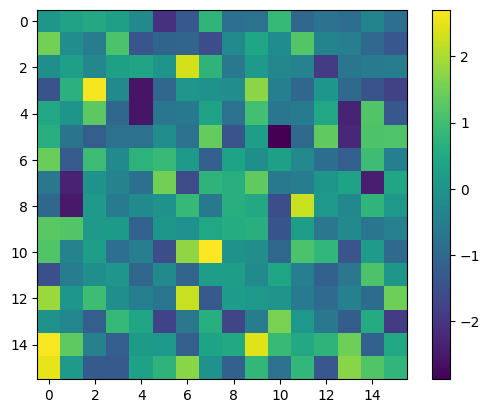

In [125]:
plt.imshow(input_tensor.detach().numpy()[0,0,...])
plt.colorbar()

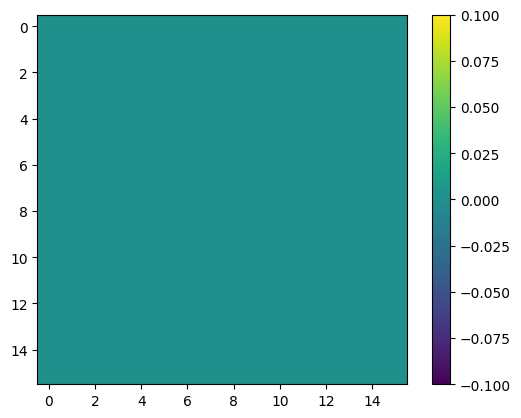

In [97]:
plt.imshow(input_tensor.detach().numpy()[0,0] - jax_input[0,...,0])
plt.colorbar()

TypeError: Invalid shape () for image data

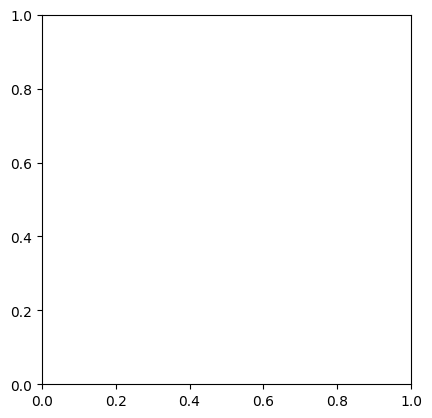

In [126]:
import matplotlib.pyplot as plt
plt.imshow((pytorch_output_transposed-jax_output_with_converted_weights_np)[0, ..., 2])
plt.colorbar()

# Scratch

In [ ]:
# class VQModel(nn.Module):
    
#     encoder: nn.Module = None
#     decoder: nn.Module = None
#     quantize: nn.Module = None
#     quant_conv: nn.Module = None
#     post_quant_conv: nn.Module = None
#     colorize: None = None
    
#     # ddconfig: dict
#     # lossconfig: dict
#     # n_embed: int
#     embed_dim: int
#     ckpt_path: str = None
#     ignore_keys: list = None
#     image_key: str = "image"
#     # colorize_nlabels: int = None
#     monitor: str = None
#     remap: None = None
#     # sane_index_shape: bool = False

#     # def setup(self):
#     #     self.encoder = Encoder(**self.ddconfig)
#     #     self.decoder = Decoder(**self.ddconfig)
#     #     self.quantize = VectorQuantizer(n_e=self.n_embed, e_dim=self.embed_dim, 
#     #                                     beta=0.25, remap=self.remap, sane_index_shape=self.sane_index_shape)
#     #     self.quant_conv = nn.Conv(self.embed_dim, (1, 1))
#     #     self.post_quant_conv = nn.Conv(self.ddconfig["z_channels"], (1, 1))

#     #     if self.colorize_nlabels is not None:
#     #         self.colorize = self.param('colorize', nn.initializers.normal(), (3, self.colorize_nlabels, 1, 1))

#     @classmethod
#     def from_params(cls, ddconfig, lossconfig, n_embed, embed_dim, 
#         ckpt_path=None, ignore_keys=None, image_key="image", colorize_nlabels=None,
#         monitor=None, remap=None, sane_index_shape=False):
#         encoder = Encoder(**ddconfig)
#         decoder = Decoder(**ddconfig)
#         quantize = VectorQuantizer(n_e=n_embed, e_dim=embed_dim, 
#                                    beta=0.25, remap=remap, sane_index_shape=sane_index_shape)
#         quant_conv = nn.Conv(embed_dim, (1, 1))
#         post_quant_conv = nn.Conv(ddconfig["z_channels"], (1, 1))

#         # What is this??
#         if colorize_nlabels is not None:
#             colorize = self.param('colorize', nn.initializers.normal(), (3, self.colorize_nlabels, 1, 1))

In [68]:
from flax import linen as nn
import jax
import jax.numpy as jnp
import optax
from flax.training import train_state

class Encoder(nn.Module):
    latent_dim: int

    def setup(self):
        self.dense1 = nn.Dense(features=128)
        self.dense2 = nn.Dense(features=64)
        self.mean_dense = nn.Dense(features=self.latent_dim)
        self.logvar_dense = nn.Dense(features=self.latent_dim)

    def __call__(self, x):
        x = nn.relu(self.dense1(x))
        x = nn.relu(self.dense2(x))
        mean = self.mean_dense(x)
        logvar = self.logvar_dense(x)
        return mean, logvar

class Decoder(nn.Module):
    output_dim: int

    def setup(self):
        self.dense1 = nn.Dense(features=64)
        self.dense2 = nn.Dense(features=128)
        self.output_dense = nn.Dense(features=self.output_dim)

    def __call__(self, z):
        z = nn.relu(self.dense1(z))
        z = nn.relu(self.dense2(z))
        z = nn.sigmoid(self.output_dense(z))
        return z

class VAE(nn.Module):
    latent_dim: int
    output_dim: int

    def setup(self):
        self.encoder = Encoder(latent_dim=self.latent_dim)
        self.decoder = Decoder(output_dim=self.output_dim)

    def reparameterize(self, mean, logvar):
        std = jnp.exp(0.5 * logvar)
        eps = jax.random.normal(self.make_rng('dropout'), mean.shape)
        return mean + eps * std

    def encode(self, x):
        return self.encoder(x)
    
    def __call__(self, x, deterministic=True):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, logvar

# Example usage
vae = VAE(latent_dim=10, output_dim=784)

rng = jax.random.PRNGKey(0)
dummy_input = jnp.ones((1, 784))  # Example input
params = vae.init(rng, dummy_input)

# Define forward pass function
def forward_pass(params, x, rng):
    return vae.apply(params, x, rngs={'dropout': rng})

# Example forward pass
rng = jax.random.PRNGKey(1)
x = jax.random.normal(rng, (1, 784))
reconstructed_x, mean, logvar = forward_pass(params, x, rng)

# Training step function
@jax.jit
def train_step(state, batch, rng):
    def loss_fn(params):
        reconstructed_x, mean, logvar = forward_pass(params, batch, rng)
        reconstruction_loss = jnp.mean(jnp.square(reconstructed_x - batch))
        kl_divergence = -0.5 * jnp.mean(1 + logvar - jnp.square(mean) - jnp.exp(logvar))
        loss = reconstruction_loss + kl_divergence
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Initialize optimizer and training state
optimizer = optax.adam(learning_rate=1e-3)
state = train_state.TrainState.create(apply_fn=vae.apply, params=params, tx=optimizer)

# Example training step
rng, step_rng = jax.random.split(rng)
state, loss = train_step(state, x, step_rng)

print(f"Training loss: {loss}")

Training loss: 1.4476189613342285


In [70]:
vae.apply(state.params, x, rngs={'dropout': rng})

(Array([[0.59782356, 0.48028037, 0.5268784 , 0.5412499 , 0.47357202,
         0.5295619 , 0.55362946, 0.40527472, 0.41515607, 0.47278085,
         0.3736489 , 0.6215862 , 0.4283234 , 0.5297417 , 0.47881293,
         0.5251219 , 0.5943308 , 0.56700146, 0.48229563, 0.5048226 ,
         0.3958562 , 0.60273117, 0.59007645, 0.4164364 , 0.54597217,
         0.53243494, 0.5871151 , 0.51926935, 0.4613332 , 0.50815547,
         0.45364735, 0.4747558 , 0.505987  , 0.5269336 , 0.38053897,
         0.55809027, 0.44448796, 0.47760388, 0.5172707 , 0.48258492,
         0.39854977, 0.57031465, 0.45915866, 0.5885839 , 0.5549953 ,
         0.4484396 , 0.41627893, 0.5520951 , 0.5824886 , 0.55574363,
         0.5655874 , 0.60568774, 0.484931  , 0.54635173, 0.5347197 ,
         0.5201308 , 0.50564045, 0.51796824, 0.5792515 , 0.5502594 ,
         0.59239864, 0.45128104, 0.53559744, 0.47412473, 0.5295527 ,
         0.46331114, 0.53153205, 0.46626937, 0.48959446, 0.5379729 ,
         0.4250202 , 0.47033706, 0

In [44]:
from flax import linen as nn
import jax.numpy as jnp
import jax

class MyModule(nn.Module):
    hidden_dim: int

    def setup(self):
        self.dense = nn.Dense(features=self.hidden_dim)
        # Define a parameter named 'bias' with a custom initialization function
        self.bias = self.param('bias', nn.initializers.zeros, (self.hidden_dim,))
        
    def __call__(self, x):
        # Apply the dense layer and add the bias parameter
        return self.compute_with_bias(x)
    
    def compute_with_bias(self, x):
        # Access the bias parameter defined in setup
        x = self.dense(x)
        return x + self.bias

# Example usage
rng = jax.random.PRNGKey(0)
dummy_input = jnp.ones((1, 10))  # Example input

# Initialize the module
module = MyModule(hidden_dim=5)
params = module.init(rng, dummy_input)

# Apply the module using the __call__ method
output = module.apply(params, dummy_input)
print(output)

# Directly call compute_with_bias using the apply method
output_direct = module.apply(params, dummy_input, method=MyModule.compute_with_bias)
print(output_direct)


[[ 0.10248458  0.2624932   0.33315787 -0.03567007  0.9329739 ]]
[[ 0.10248458  0.2624932   0.33315787 -0.03567007  0.9329739 ]]
